In [23]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchinfo import summary
import numpy

In [25]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [26]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [27]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), # output_size = 26
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05),
        )

        # Convolution 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False), # output_size = 24
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(0.05),
        )

        # Transition 1
        self.trans1 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False), # output_size = 24
            nn.MaxPool2d(2, 2), # output_size = 12
        )

        # Convolution 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False), # output_size = 10
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(0.05),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), # output_size = 8
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), # output_size = 6
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05),
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False), # output_size = 6
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05),
        )

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.gap(x)
        x = self.conv6(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [30]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
batch_size = 20
s = summary(
    model,
    input_size=(batch_size, 1, 28, 28),
    verbose=1,
    col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds", "trainable"],
    row_settings=["var_names"]
)

cuda
Layer (type (var_name))                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
Net (Net)                                --                        [20, 1, 28, 28]           [20, 10]                  --                        --                        True
├─Sequential (conv0)                     --                        [20, 1, 28, 28]           [20, 10, 26, 26]          --                        --                        True
│    └─Conv2d (0)                        [3, 3]                    [20, 1, 28, 28]           [20, 10, 26, 26]          90                        1,216,800                 True
│    └─ReLU (1)                          --                        [20, 10, 26, 26]          [20, 10, 26, 26]          --                        --                        --
│    └─BatchNorm2d (2)                   --                        [20, 10, 26, 26]          [20, 10, 26, 26]   

In [31]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

epoch_train_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'LR={optimizer.param_groups[0]["lr"]} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  # epoch accuracy = accuracy for the whole batch
  epoch_train_acc.append(100*correct/processed)
  return 100*correct/processed

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [32]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=0)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    accuracy = train(model, device, train_loader, optimizer, epoch)
    scheduler.step(accuracy)
    test(model, device, test_loader)

EPOCH: 0


LR=0.3 Loss=0.10052492469549179 Batch_id=468 Accuracy=92.53: 100%|██████████| 469/469 [00:11<00:00, 41.80it/s]


Test set: Average loss: 0.0708, Accuracy: 9773/10000 (97.73%)

EPOCH: 1


LR=0.3 Loss=0.0738702341914177 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:10<00:00, 43.31it/s]


Test set: Average loss: 0.0547, Accuracy: 9829/10000 (98.29%)

EPOCH: 2


LR=0.3 Loss=0.07748309522867203 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:10<00:00, 45.60it/s]


Test set: Average loss: 0.0470, Accuracy: 9847/10000 (98.47%)

EPOCH: 3


LR=0.3 Loss=0.04231597110629082 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:10<00:00, 45.03it/s]


Test set: Average loss: 0.0451, Accuracy: 9854/10000 (98.54%)

EPOCH: 4


LR=0.3 Loss=0.0378556102514267 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:10<00:00, 43.88it/s]


Test set: Average loss: 0.0463, Accuracy: 9845/10000 (98.45%)

EPOCH: 5


LR=0.3 Loss=0.002487816382199526 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:10<00:00, 44.96it/s]


Test set: Average loss: 0.0321, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


LR=0.3 Loss=0.06639277189970016 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:10<00:00, 45.20it/s]


Test set: Average loss: 0.0259, Accuracy: 9920/10000 (99.20%)

EPOCH: 7


LR=0.03 Loss=0.006606352981179953 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:10<00:00, 45.37it/s]


Test set: Average loss: 0.0202, Accuracy: 9940/10000 (99.40%)

EPOCH: 8


LR=0.03 Loss=0.006661152467131615 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:10<00:00, 44.49it/s]


Test set: Average loss: 0.0196, Accuracy: 9944/10000 (99.44%)

EPOCH: 9


LR=0.03 Loss=0.035634495317935944 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:10<00:00, 43.33it/s]


Test set: Average loss: 0.0199, Accuracy: 9944/10000 (99.44%)

EPOCH: 10


LR=0.03 Loss=0.007258403580635786 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:10<00:00, 45.45it/s]


Test set: Average loss: 0.0188, Accuracy: 9950/10000 (99.50%)

EPOCH: 11


LR=0.003 Loss=0.06524588167667389 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:10<00:00, 45.26it/s]


Test set: Average loss: 0.0190, Accuracy: 9946/10000 (99.46%)

EPOCH: 12


LR=0.003 Loss=0.007336366456001997 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:10<00:00, 44.68it/s]


Test set: Average loss: 0.0180, Accuracy: 9949/10000 (99.49%)

EPOCH: 13


LR=0.003 Loss=0.019015980884432793 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:10<00:00, 45.59it/s]


Test set: Average loss: 0.0184, Accuracy: 9946/10000 (99.46%)

EPOCH: 14


LR=0.00030000000000000003 Loss=0.0026494336780160666 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:10<00:00, 45.44it/s]


Test set: Average loss: 0.0188, Accuracy: 9948/10000 (99.48%)



Text(0.5, 1.0, 'Test Accuracy')

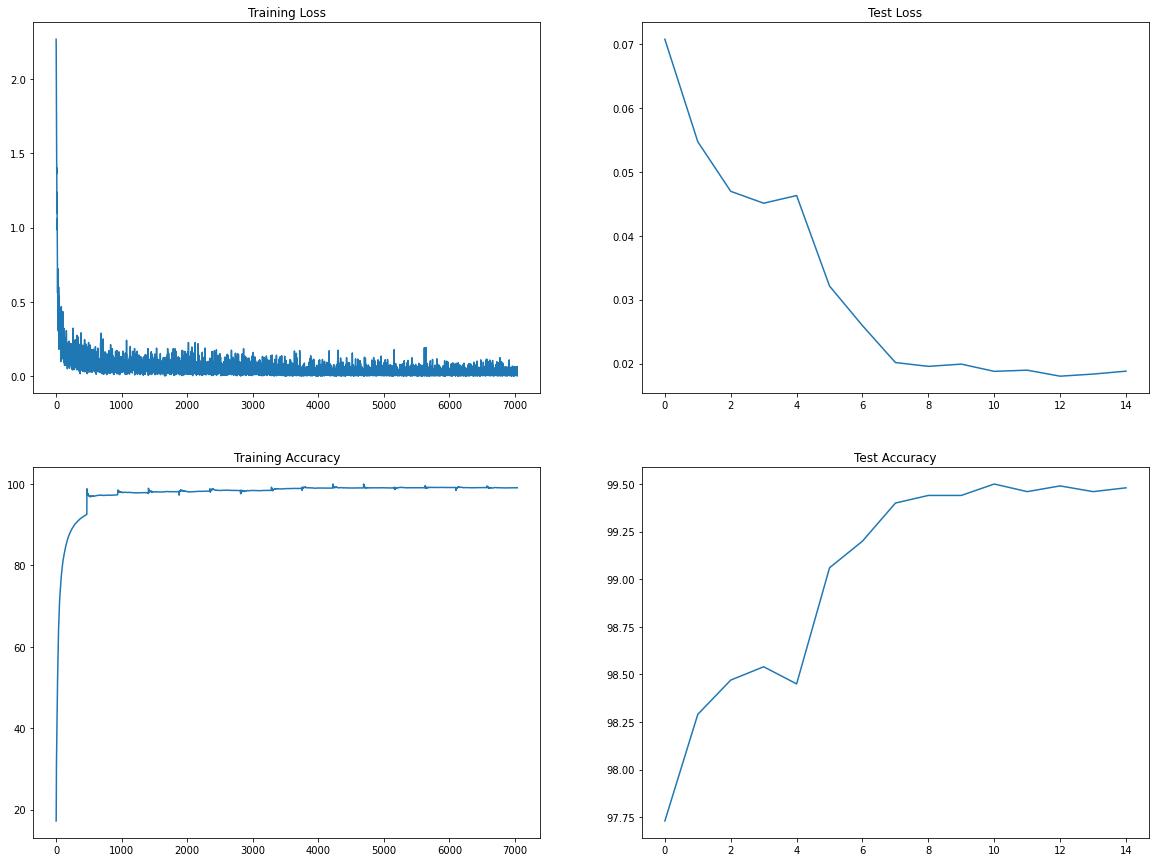

In [33]:
fig, axs = plt.subplots(2,2,figsize=(20,15))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [34]:
print("Minimum training loss = {:.9f}%".format(min(train_losses)))
print("Minimum testing loss = {:.9f}%".format(min(test_losses)))
print("Best training accuracy = {:.2f}%".format(max(epoch_train_acc)))
print("Best testing accuracy = {:.2f}%".format(max(test_acc)))

Minimum training loss = 0.000797290%
Minimum testing loss = 0.018021763%
Best training accuracy = 99.14%
Best testing accuracy = 99.50%


# Target:

1.  Changed LR scheduler to ReduceLROnPlateau
    * Initial LR = 0.3
    * factor = 0.1
    * patience = 0
    * mode = max
    * metric to be maximized = accuracy, which I'm returning from the train function
2.  Reduced the number of parameters from 13,808 to 7,750

# Results:

*   Parameters = 7,750
*   Best training accuracy = 99.14%
*   Best testing accuracy = 99.50%

# Analysis:

*   Model well within target size, even less than 8,000
*   Model is under-fitting as expected.
*   We reached our target testing accuracy faster and more consistently
    *  99.44% at Epoch 7
    *  99.44% at Epoch 8
    *  99.44% at Epoch 9
    *  99.50% at Epoch 10
    *  99.46% at Epoch 11
    *  99.49% at Epoch 12
    *  99.46% at Epoch 13
    *  99.48% at Epoch 14
*   Overall testing accuracy is up and we achieved our target during the last 8 epochs. And accuracy overall is high during the later epochs.